In [1]:
import jupyter_utils as j

j.reload(j)

In [114]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [153]:
data = pd.read_csv('sparkify_data_final.csv')
data = data.drop(['userId'] ,axis = 1)

pd.set_option('use_inf_as_na', True)

data['days_time_away'] = (data.session_avg_time_away / data.n_days) / data.avg_session_duration

print(len(data))

data = data.dropna()

print(len(data))

# data = data.drop(['time_window'], axis = 1)

448
448


In [154]:
data.head(10)

,male,paid,canceled,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window,days_time_away
0,0,0,1,68.500000,3.507733,137,1,22,2,3,0,0,3,0,3,4,2,0,96,0,19.536542,0.142602,3.137255,0.427807,0.000000,0.427807,0.000000,0.427807,0.570410,1.024795,0.000000,13.689840,66.022500,73.035000,9.410992
1,1,0,1,65.833333,5.758219,395,6,11,6,5,0,0,2,1,23,15,5,2,310,1,18.018703,0.273702,0.501787,0.228085,0.000000,0.091234,0.045617,1.049190,0.684255,0.997185,0.091234,14.141261,166.991528,689.887778,4.833426
2,0,1,1,30.400000,2.761294,152,3,9,5,0,0,0,2,2,7,8,5,1,112,1,18.797018,0.370994,1.112981,0.000000,0.000000,0.247329,0.247329,0.865652,0.989317,0.972627,0.123665,13.850435,47.248056,197.078611,3.422168
3,1,0,0,28.000000,2.938208,84,2,6,3,1,0,0,3,2,2,3,3,3,62,0,19.768582,0.470681,1.412042,0.235340,0.000000,0.706021,0.470681,0.470681,0.706021,1.033783,0.706021,14.591096,522.412639,1049.074444,59.266589
4,0,1,1,107.800000,14.717388,2156,45,1,20,15,0,0,26,10,70,102,17,15,1826,0,17.074185,0.356372,0.007919,0.118791,0.000000,0.205904,0.079194,0.554357,0.807777,1.067369,0.118791,14.460789,53.600208,983.875833,0.182098
5,1,1,1,54.666667,7.115083,328,8,1,6,1,0,2,3,0,17,16,5,2,266,0,17.916698,0.436993,0.054624,0.054624,0.109248,0.163872,0.000000,0.928609,0.873985,1.013841,0.109248,14.530005,87.977986,370.218889,2.060833
6,1,0,0,40.000000,3.818930,600,6,35,15,4,0,0,16,3,36,12,15,5,462,0,18.872046,0.188720,1.100869,0.125814,0.000000,0.503255,0.094360,1.132323,0.377441,1.013385,0.157267,14.531475,95.152480,1363.927778,1.661067
7,1,0,1,25.833333,1.925077,155,4,9,6,3,0,0,2,0,6,5,7,1,122,0,19.535079,0.504131,1.134295,0.378098,0.000000,0.252066,0.000000,0.756197,0.630164,1.054349,0.126033,15.375998,60.725833,372.289444,5.257437
8,1,0,0,18.625000,1.202651,149,0,13,8,0,0,0,6,0,6,6,8,3,112,0,20.467033,0.000000,1.785714,0.000000,0.000000,0.824176,0.000000,0.824176,0.824176,1.069652,0.412088,15.384615,201.516190,1417.893333,20.944999
9,0,1,0,138.222222,21.700945,1244,25,0,9,10,0,1,21,11,43,50,5,3,1048,0,17.075793,0.343163,0.000000,0.137265,0.013727,0.288257,0.150992,0.590240,0.686326,1.005280,0.041180,14.385395,269.713125,1151.704167,1.380959


In [5]:
data.canceled.value_counts()

0    17275
1     5003
Name: canceled, dtype: int64

In [6]:
data.male.value_counts()

1    11651
0    10627
Name: male, dtype: int64

In [7]:
data.paid.value_counts()

1    11275
0    11003
Name: paid, dtype: int64

In [155]:
def plot_roc_curve(y_test, y_predictions, model):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary'))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .3, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model)
    plot_metrics(y_test, y_predicted)
    
    #y_predicted = model.predict(X_test)
    #plot_roc_curve(y_test, y_predicted, model)
    #plot_metrics(y_test, y_predicted)
    
    return model

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label): 
    gbl = GradientBoostingClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, random_state = 42)
    return train_model(df, label, gbl)


In [156]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Filter average or absolute columns
features_to_normalize = list(filter(lambda column_name: '_' in column_name, data.columns))

_x = data.copy()
_x[features_to_normalize] = RobustScaler().fit_transform(_x[features_to_normalize])
_x = _x.drop(list(filter(lambda column_name: 'n_pppppp' in column_name, _x.columns)), axis = 1)

_x.head(10)

,male,paid,canceled,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window,days_time_away
0,0,0,1,-0.063579,-0.492921,-0.415341,-0.465116,0.516129,-0.533333,-0.226415,0.0,0.0,-0.333333,-0.428571,-0.500000,-0.356877,-0.538462,-0.500,-0.417567,-1.0,0.894349,-1.932541,3.158362,2.796774,0.000000,1.035328,-1.065205,-0.828040,-0.697104,0.262967,-1.318481,-1.723637,-0.229447,-1.648777,1.769328
1,1,0,1,-0.112019,-0.226773,-0.222264,-0.310078,0.043011,-0.266667,-0.075472,0.0,0.0,-0.380952,-0.285714,-0.083333,-0.193309,-0.307692,-0.250,-0.220740,0.0,0.030799,-0.973990,0.192973,0.844879,0.000000,-1.029571,-0.466486,1.344781,-0.196717,-0.442540,-0.021461,-0.859734,0.649705,-0.705178,0.800265
2,0,1,1,-0.755677,-0.581197,-0.404116,-0.403101,-0.043011,-0.333333,-0.452830,0.0,0.0,-0.380952,-0.142857,-0.416667,-0.297398,-0.307692,-0.375,-0.402851,0.0,0.473609,-0.262627,0.880680,-1.384200,0.000000,-0.071917,2.180971,0.702993,1.144140,-1.070042,0.439587,-1.416300,-0.392919,-1.459028,0.501505
3,1,0,0,-0.799273,-0.560275,-0.455005,-0.434109,-0.172043,-0.466667,-0.377358,0.0,0.0,-0.333333,-0.142857,-0.520833,-0.371747,-0.461538,-0.125,-0.448839,-1.0,1.026365,0.466246,1.217178,0.915787,0.000000,2.742184,5.112439,-0.678124,-0.101046,0.492618,8.718605,0.001136,3.744411,-0.155730,12.323671
4,0,1,1,0.650318,0.832761,1.095603,0.899225,-0.387097,0.666667,0.679245,0.0,0.0,0.761905,1.000000,0.895833,1.100372,0.615385,1.375,1.173603,-1.0,-0.506569,-0.369535,-0.362719,-0.223255,0.000000,-0.326064,-0.025793,-0.385529,0.346207,1.350823,0.370298,-0.248239,-0.337610,-0.255464,-0.184412
5,1,1,1,-0.314865,-0.066307,-0.272404,-0.248062,-0.387097,-0.266667,-0.377358,0.0,1.0,-0.333333,-0.428571,-0.208333,-0.178439,-0.307692,-0.250,-0.261209,-1.0,-0.027235,0.219933,-0.310167,-0.850358,4.890241,-0.583931,-1.065205,0.923139,0.637217,-0.016926,0.234637,-0.115777,-0.038278,-1.194175,0.213312
6,1,0,0,-0.581290,-0.456119,-0.068849,-0.310078,1.075269,0.333333,-0.150943,0.0,0.0,0.285714,0.000000,0.187500,-0.237918,0.461538,0.125,-0.080938,-1.0,0.516295,-1.595343,0.867052,-0.154620,0.000000,1.498201,0.173265,1.635474,-1.545271,-0.028578,0.917293,-0.112964,0.024192,0.325901,0.128683
7,1,0,1,-0.838632,-0.680090,-0.401871,-0.372093,-0.043011,-0.266667,-0.226415,0.0,0.0,-0.380952,-0.428571,-0.437500,-0.342007,-0.153846,-0.375,-0.393654,-1.0,0.893517,0.710825,0.904662,2.310965,0.000000,-0.042859,-1.065205,0.320255,-0.434465,1.018150,0.473254,1.503234,-0.275566,-1.191008,0.890028
8,1,0,0,-0.969573,-0.765526,-0.406361,-0.496124,0.129032,-0.133333,-0.452830,0.0,0.0,-0.190476,-0.428571,-0.437500,-0.327138,-0.076923,-0.125,-0.402851,-1.0,1.423737,-2.975198,1.637629,-1.384200,0.000000,3.467073,-1.065205,0.557961,0.418287,1.409164,4.539933,1.519726,0.950317,0.408452,4.211057
9,0,1,0,1.202947,1.658654,0.413096,0.279070,-0.430108,-0.066667,0.301887,0.0,0.5,0.523810,1.142857,0.333333,0.327138,-0.307692,-0.125,0.458036,-1.0,-0.505654,-0.466115,-0.371629,-0.042704,0.614436,0.179177,0.916549,-0.260053,-0.187612,-0.235682,-0.733055,-0.392523,1.544118,0.001262,0.069384


In [ ]:
_x[_x.columns[4:]].apply(lambda x: x/_x.time_window, axis = 1)

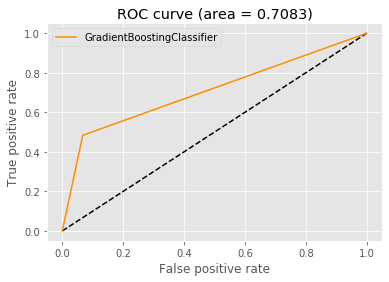

[[15 16]
 [ 7 97]]

accuracy................. 0.8296
precision................ 0.8584
recall................... 0.9327
auc...................... 0.7083
F1 macro................. 0.7300
F1 micro................. 0.8296
F1 weighted.............. 0.8187
F1 binary................ 0.5660


In [141]:
model = train_gradient_boosting(_x, 'canceled')

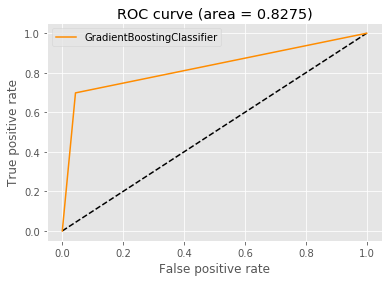

[[1060  458]
 [ 224 4942]]

accuracy................. 0.8980
precision................ 0.9152
recall................... 0.9566
auc...................... 0.8275
F1 macro................. 0.8460
F1 micro................. 0.8980
F1 weighted.............. 0.8948
F1 binary................ 0.7566


In [17]:
model = train_gradient_boosting(_x, 'canceled')

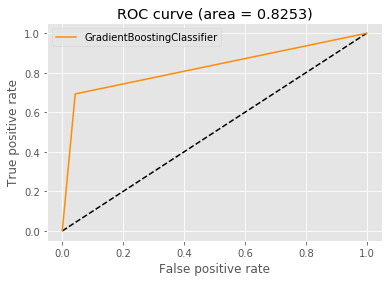

[[1052  466]
 [ 219 4947]]

accuracy................. 0.8975
precision................ 0.9139
recall................... 0.9576
auc...................... 0.8253
F1 macro................. 0.8448
F1 micro................. 0.8975
F1 weighted.............. 0.8942
F1 binary................ 0.7544


In [36]:
model = train_gradient_boosting(_x, 'canceled')

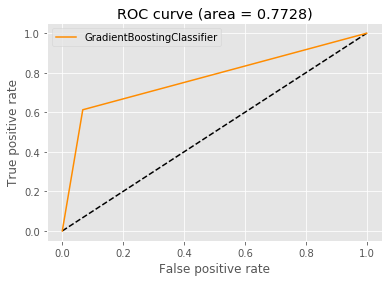

[[19 12]
 [ 7 97]]

accuracy................. 0.8593
precision................ 0.8899
recall................... 0.9327
auc...................... 0.7728
F1 macro................. 0.7887
F1 micro................. 0.8593
F1 weighted.............. 0.8547
F1 binary................ 0.6667


In [43]:
model = train_gradient_boosting(_x, 'canceled')

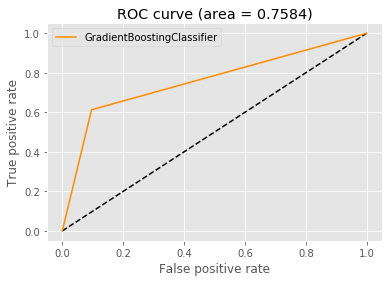

[[19 12]
 [10 94]]

accuracy................. 0.8370
precision................ 0.8868
recall................... 0.9038
auc...................... 0.7584
F1 macro................. 0.7643
F1 micro................. 0.8370
F1 weighted.............. 0.8351
F1 binary................ 0.6333


In [13]:
model = train_gradient_boosting(_x, 'canceled')

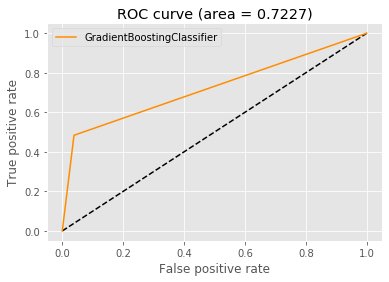

[[ 15  16]
 [  4 100]]

accuracy................. 0.8519
precision................ 0.8621
recall................... 0.9615
auc...................... 0.7227
F1 macro................. 0.7545
F1 micro................. 0.8519
F1 weighted.............. 0.8381
F1 binary................ 0.6000


In [107]:
model = train_gradient_boosting(_x, 'canc')

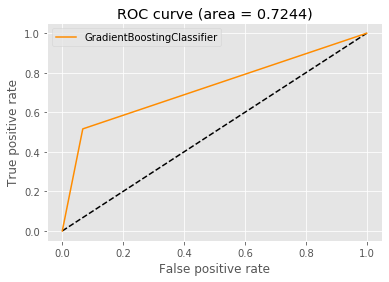

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


In [101]:
model = train_gradient_boosting(_x, 'canc')

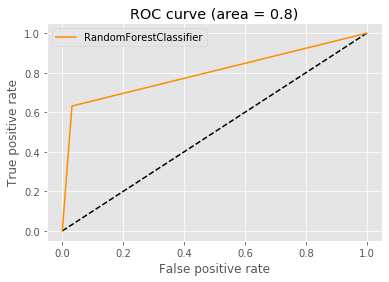

[[ 959  559]
 [ 164 5002]]

accuracy................. 0.8918
precision................ 0.8995
recall................... 0.9683
auc...................... 0.8000
F1 macro................. 0.8294
F1 micro................. 0.8918
F1 weighted.............. 0.8857
F1 binary................ 0.7262


In [8]:
model = train_random_forest(_x, 'canceled')

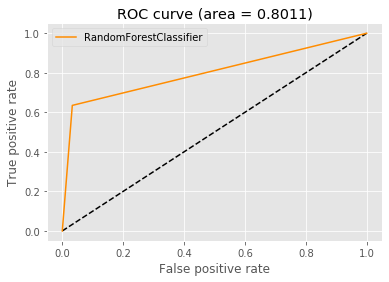

[[ 964  554]
 [ 170 4996]]

accuracy................. 0.8917
precision................ 0.9002
recall................... 0.9671
auc...................... 0.8011
F1 macro................. 0.8297
F1 micro................. 0.8917
F1 weighted.............. 0.8858
F1 binary................ 0.7270


In [13]:
model = train_random_forest(_x, 'canceled')

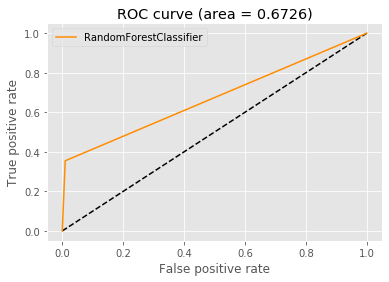

[[ 11  20]
 [  1 103]]

accuracy................. 0.8444
precision................ 0.8374
recall................... 0.9904
auc...................... 0.6726
F1 macro................. 0.7096
F1 micro................. 0.8444
F1 weighted.............. 0.8166
F1 binary................ 0.5116


In [44]:
model = train_random_forest(_x, 'canceled')

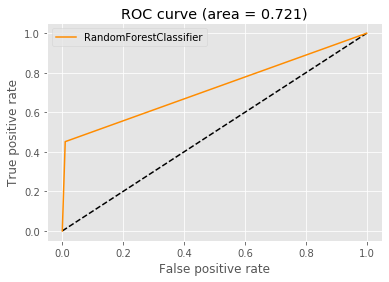

[[ 14  17]
 [  1 103]]

accuracy................. 0.8667
precision................ 0.8583
recall................... 0.9904
auc...................... 0.7210
F1 macro................. 0.7642
F1 micro................. 0.8667
F1 weighted.............. 0.8482
F1 binary................ 0.6087


In [14]:
model = train_random_forest(_x, 'canceled')

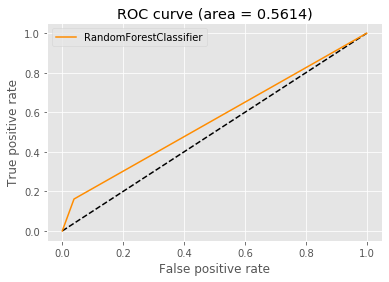

[[  5  26]
 [  4 100]]

accuracy................. 0.7778
precision................ 0.7937
recall................... 0.9615
auc...................... 0.5614
F1 macro................. 0.5598
F1 micro................. 0.7778
F1 weighted.............. 0.7273
F1 binary................ 0.2500


In [102]:
model = train_random_forest(_x, 'canc')

In [ ]:
importances = pd.Series(model.feature_importances_, index = average_columns).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

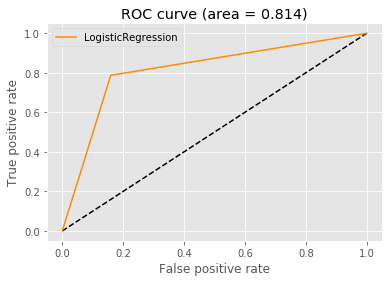

[[1195  323]
 [ 823 4343]]

accuracy................. 0.8285
precision................ 0.9308
recall................... 0.8407
auc...................... 0.8140
F1 macro................. 0.7797
F1 micro................. 0.8285
F1 weighted.............. 0.8363
F1 binary................ 0.6759


In [9]:
model = train_logistic_regression(_x, 'canceled')

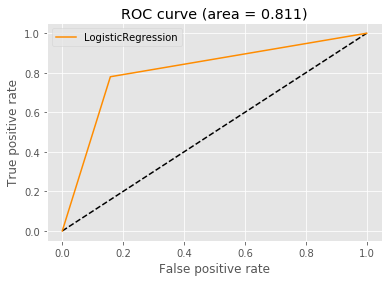

[[1184  334]
 [ 816 4350]]

accuracy................. 0.8279
precision................ 0.9287
recall................... 0.8420
auc...................... 0.8110
F1 macro................. 0.7782
F1 micro................. 0.8279
F1 weighted.............. 0.8355
F1 binary................ 0.6731


In [14]:
model = train_logistic_regression(_x, 'canceled')

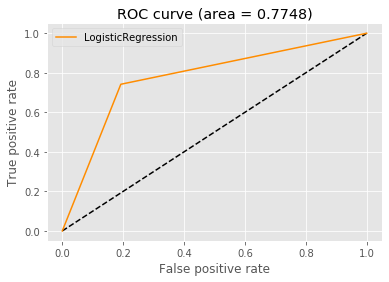

[[23  8]
 [20 84]]

accuracy................. 0.7926
precision................ 0.9130
recall................... 0.8077
auc...................... 0.7748
F1 macro................. 0.7394
F1 micro................. 0.7926
F1 weighted.............. 0.8031
F1 binary................ 0.6216


In [45]:
model = train_logistic_regression(_x, 'canceled')

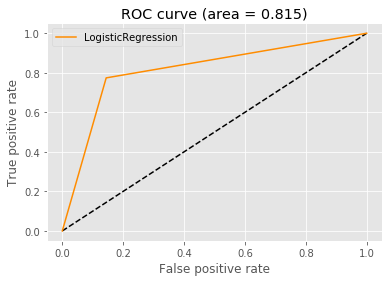

[[24  7]
 [15 89]]

accuracy................. 0.8370
precision................ 0.9271
recall................... 0.8558
auc...................... 0.8150
F1 macro................. 0.7879
F1 micro................. 0.8370
F1 weighted.............. 0.8431
F1 binary................ 0.6857


In [16]:
model = train_logistic_regression(_x, 'canceled')

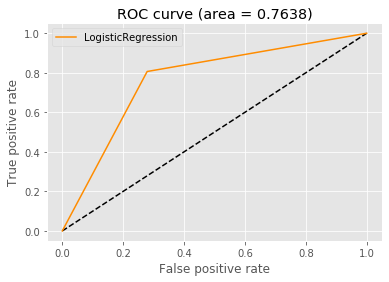

[[25  6]
 [29 75]]

accuracy................. 0.7407
precision................ 0.9259
recall................... 0.7212
auc...................... 0.7638
F1 macro................. 0.6995
F1 micro................. 0.7407
F1 weighted.............. 0.7597
F1 binary................ 0.5882


In [142]:
model = train_logistic_regression(_x, 'canceled')